In [1]:
%matplotlib inline

from __future__ import print_function
import os
import sys
from operator import add, itemgetter
import json
from gzip import GzipFile
from functools import partial
from collections import OrderedDict
import pickle

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATDIR = "."
DATFILES = [
    "teslatweet_2017-1-5.gz",
    "teslatweet_2017-1-6.gz",
]
LABELED = ["tesla_tweets_rand_for_label_2017-1-6_labeled.csv"]
label_key_f = 'labels_tesla.txt'

## Labels

In [3]:
with open(label_key_f) as f:
    label_key = f.read()
print(label_key)

0 = can't judge (in another language, only a link, etc)
n = not about tesla company/product
m = only about Musk himself
v = about business, news, current events
i = by an individual
c = by a company
d = individual consumer desire/opinion
b = intent to buy
+- = positive or negative sentiment


In [4]:
lab = pd.read_csv(LABELED[0])

In [5]:
lab['labels'] = lab['labels'].fillna('')

In [6]:
lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4695 entries, 0 to 4694
Data columns (total 9 columns):
id_str              4695 non-null int64
created_at          4695 non-null object
user_name           4695 non-null object
user_screen_name    4695 non-null object
user_protected      4695 non-null bool
user_verified       4695 non-null bool
lang                4695 non-null object
labels              4695 non-null object
text                4695 non-null object
dtypes: bool(2), int64(1), object(6)
memory usage: 266.0+ KB


In [7]:
lab['labels'].value_counts()

       4379
v       123
0        47
vi       46
n        45
m        16
d+       11
vc       10
d-        3
d         3
cv        2
id        2
i         1
di        1
db+       1
ni        1
c+        1
id+       1
iv        1
vi-       1
Name: labels, dtype: int64

In [8]:
(lab['labels'] == '').value_counts()

True     4379
False     316
Name: labels, dtype: int64

In [9]:
def str_to_bool_series(s, prefix='label_'):
    return pd.Series({prefix + char: True for char in s})

def str_to_bool_df_row(s):
    return pd.DataFrame.from_records({char: True for char in s})

def iter_to_bool_cols(series, field, prefix='label_'):
    return pd.concat([series, str_to_bool_series(series.loc[field], prefix=prefix)])


In [10]:
lab2 = lab.apply(partial(iter_to_bool_cols, field='labels', prefix='L_'), axis=1)

In [11]:
label_cols = [col for col in lab2.columns if col.startswith('L_')]
lab2.loc[:, label_cols] = lab2.loc[:, label_cols].fillna(False)

In [12]:
lab2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4695 entries, 0 to 4694
Data columns (total 19 columns):
L_+                 4695 non-null bool
L_-                 4695 non-null bool
L_0                 4695 non-null bool
L_b                 4695 non-null bool
L_c                 4695 non-null bool
L_d                 4695 non-null bool
L_i                 4695 non-null bool
L_m                 4695 non-null bool
L_n                 4695 non-null bool
L_v                 4695 non-null bool
created_at          4695 non-null object
id_str              4695 non-null int64
labels              4695 non-null object
lang                4695 non-null object
text                4695 non-null object
user_name           4695 non-null object
user_protected      4695 non-null bool
user_screen_name    4695 non-null object
user_verified       4695 non-null bool
dtypes: bool(12), int64(1), object(6)
memory usage: 311.9+ KB


In [13]:
lab2.groupby(['L_d', 'L_b']).size()

L_d    L_b  
False  False    4673
True   False      21
       True        1
dtype: int64

In [14]:
lab3 = lab2.ix[lab2['labels'] != '']
lab3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 0 to 315
Data columns (total 19 columns):
L_+                 316 non-null bool
L_-                 316 non-null bool
L_0                 316 non-null bool
L_b                 316 non-null bool
L_c                 316 non-null bool
L_d                 316 non-null bool
L_i                 316 non-null bool
L_m                 316 non-null bool
L_n                 316 non-null bool
L_v                 316 non-null bool
created_at          316 non-null object
id_str              316 non-null int64
labels              316 non-null object
lang                316 non-null object
text                316 non-null object
user_name           316 non-null object
user_protected      316 non-null bool
user_screen_name    316 non-null object
user_verified       316 non-null bool
dtypes: bool(12), int64(1), object(6)
memory usage: 23.5+ KB


## Merge with Features

In [15]:
rawlines = []
rawtext = ''
for F in DATFILES:
    with GzipFile(os.path.join(DATDIR, F)) as f:
        rawlines.extend(f.readlines())
        f.seek(0)
        rawtext += f.read().decode(encoding='utf-8')


In [16]:
rawlines2 = rawtext.split('\n')
rawlines2 = tuple(set(filter(bool, rawlines2)))

In [17]:
(
    (len(rawlines), sum(map(len, rawlines))),
    (len(rawlines2), sum(map(len, rawlines2)))
)

((9172, 53131676), (9166, 53089832))

In [18]:
records = tuple(map(json.loads, rawlines2))

In [19]:
full = pd.DataFrame.from_records(records)

In [20]:
user_df = pd.DataFrame.from_items(full['user'].iteritems()).T
user_df.columns = ['user_' + c for c in user_df.columns]
full2 = pd.concat([full, user_df], axis=1)
# del full2['user']

In [21]:
full2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9166 entries, 0 to 9165
Data columns (total 71 columns):
contributors                               0 non-null object
coordinates                                6 non-null object
created_at                                 9166 non-null object
display_text_range                         1359 non-null object
entities                                   9166 non-null object
extended_entities                          3636 non-null object
extended_tweet                             233 non-null object
favorite_count                             9166 non-null int64
favorited                                  9166 non-null bool
filter_level                               9166 non-null object
geo                                        6 non-null object
id                                         9166 non-null int64
id_str                                     9166 non-null object
in_reply_to_screen_name                    448 non-null object
in_reply_to_

In [22]:
full2.text.value_counts().head()

RT @historyimg: 1月7日はニコラ・テスラの命日\nNikola Tesla (1856-1943)\n\n数百万ボルトが放電する横で読書するニコラ・テスラ https://t.co/qe7qij6hYa                                   2426
RT @ReformedBroker: If you drive off in a stolen Tesla, it becomes an Edison.                                                                    297
RT @MKBHD: For everyone saying I should compare the Tesla to the Faraday Future FF91... I rode in it, and a video is coming... https://t.co…     179
RT @BillRattner: Tesla/Blockchain UAE GovHack Preview https://t.co/aaAtTGhpJj via @YouTube                                                       102
RT @MachineVids: Tesla Coil https://t.co/el93VKEPaI                                                                                               90
Name: text, dtype: int64

In [23]:
lab_meta = full2.merge(
    lab3,
    how='right', 
    left_on='text', 
    right_on='text',
    suffixes=('', '_LABELVERS')
)

In [24]:
lab_meta.set_index('id', drop=False, inplace=True, verify_integrity=True)

In [25]:
lab_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4201 entries, 817106587190001664 to 817466399304142849
Data columns (total 89 columns):
contributors                               0 non-null object
coordinates                                0 non-null object
created_at                                 4201 non-null object
display_text_range                         75 non-null object
entities                                   4201 non-null object
extended_entities                          2782 non-null object
extended_tweet                             16 non-null object
favorite_count                             4201 non-null int64
favorited                                  4201 non-null bool
filter_level                               4201 non-null object
geo                                        0 non-null object
id                                         4201 non-null int64
id_str                                     4201 non-null object
in_reply_to_screen_name                    26 n

### Balance out the classes

In [26]:
pos_ixs = lab_meta.ix[lab_meta['L_d'], 'id']
neg_ixs = lab_meta.ix[~lab_meta['L_d'], 'id']

In [27]:
tuple(map(len, (pos_ixs, neg_ixs)))

(283, 3918)

In [28]:
pos_ixs_upsamp = np.random.choice(pos_ixs, 3000)

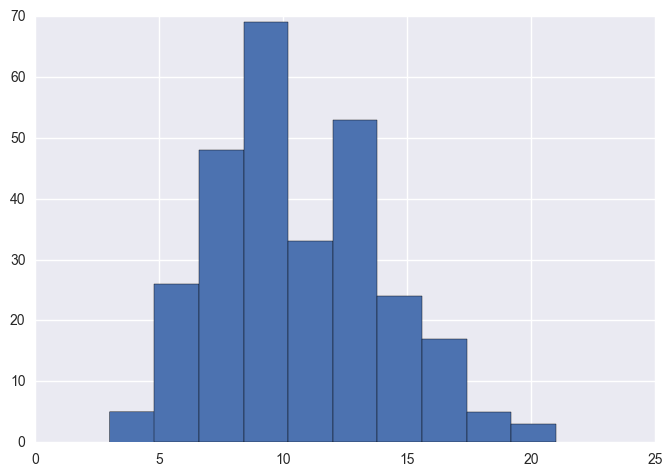

In [29]:
pd.Series(pos_ixs_upsamp).value_counts().hist()

## Create features

### Explore possible features

Entities: get number of hashtags, symbols, urls, and user_mentions

In [30]:
full2['entities'].iloc[0]

{'hashtags': [],
 'symbols': [],
 'urls': [{'display_url': 'tesla.com/blog/battery-c…',
   'expanded_url': 'https://www.tesla.com/blog/battery-cell-production-begins-gigafactory',
   'indices': [67, 90],
   'url': 'https://t.co/xrFl4tChBx'}],
 'user_mentions': [{'id': 13298072,
   'id_str': '13298072',
   'indices': [3, 15],
   'name': 'Tesla',
   'screen_name': 'TeslaMotors'}]}

In [31]:
full2['entities'].iloc[0].keys()

dict_keys(['symbols', 'hashtags', 'urls', 'user_mentions'])

In [33]:
def get_val_len(dict_, key):
    return len(dict_[key])

def entity_val_len_getter(field, subfield):
    def get_entity_val_len(df):
        return df[field].map(partial(get_val_len, key=subfield))
    return get_entity_val_len
    


In [34]:
_x = full2['entities'].map(partial(get_val_len, key='hashtags'))

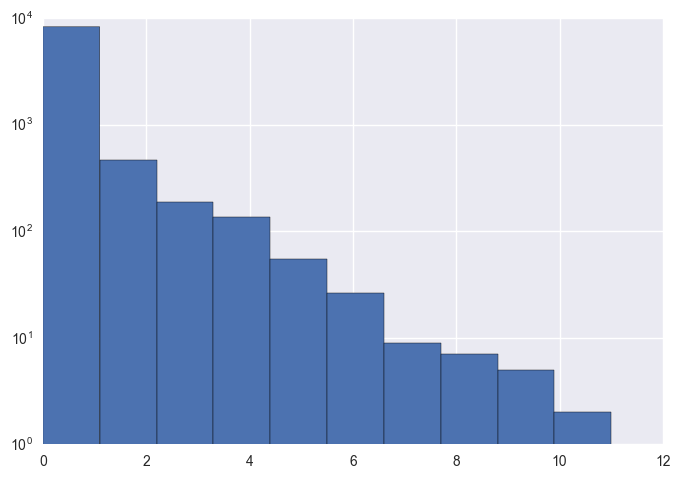

In [35]:
_x.hist(log=True)

### Extract all features

In [36]:
def func_applier(df, func_dict):
    """keys are the labels for the output series. Values are funcs 
    expecting a series"""
    return pd.DataFrame(
        OrderedDict((
            (name, func(df)) 
            for name, func in func_dict.items()
        )), 
        index=df.index
    )


In [37]:
def get_label(rec, label_col='L_d'):
    return rec[label_col]

feat_only_funcs = OrderedDict(
    (
        ('text_len', lambda rec: rec['text'].str.len()),
        ('user_protected', lambda rec: rec['user_protected']),
        ('user_verified', lambda rec: rec['user_verified']),
        ('is_quote', lambda rec: rec['quoted_status'].isnull()),
        ('is_retweet', lambda rec: rec['retweeted_status'].isnull()),
        ('user_mentions_n', entity_val_len_getter('entities', 'user_mentions')),
        ('urls_n', entity_val_len_getter('entities', 'urls')),
        ('hashtags_n', entity_val_len_getter('entities', 'hashtags')),
        ('symbols_n', entity_val_len_getter('entities', 'symbols')),
    )
)

feat_funcs = OrderedDict(
    (('L_d', get_label),) + tuple(feat_only_funcs.items())
)

def is_field_nonnull(obj, field):
    """Check whether obj[field] is null (None or numpy.nan)"""
    if field not in obj:
        return False
    else:
        return not pd.isnull(obj[field])

def subfield_getter(obj, field_seq):
    """Recursively get items from obj based on field_seq"""
    if len(field_seq) == 0:
        return obj
    elif field_seq[0] not in obj:
        return None
    else:
        return subfield_getter(obj[field_seq[0]], field_seq[1:])

def subfield_func_apply(obj, field_seq, func=len):
    return func(subfield_getter(obj, field_seq))



feat_only_per_rec_funcs = OrderedDict(
    (
        ('text_len', partial(subfield_func_apply, field_seq=('text',), func=len)),
        ('user_protected', partial(subfield_getter, field_seq=('user', 'protected'))),
        ('user_verified', partial(subfield_getter, field_seq=('user', 'verified'))),
        ('is_quote', partial(is_field_nonnull, field='quoted_status')),
        ('is_retweet', partial(is_field_nonnull, field='retweeted_status')),
        ('user_mentions_n', partial(subfield_func_apply, field_seq=('entities', 'user_mentions'), func=len)),
        ('urls_n', partial(subfield_func_apply, field_seq=('entities', 'urls'), func=len)),
        ('hashtags_n', partial(subfield_func_apply, field_seq=('entities', 'hashtags'), func=len)),
        ('symbols_n', partial(subfield_func_apply, field_seq=('entities', 'symbols'), func=len)),
    )
)


In [38]:
feat_funcs.keys()

odict_keys(['L_d', 'text_len', 'user_protected', 'user_verified', 'is_quote', 'is_retweet', 'user_mentions_n', 'urls_n', 'hashtags_n', 'symbols_n'])

In [39]:
feats_df = func_applier(lab_meta, feat_funcs)

In [40]:
feats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4201 entries, 817106587190001664 to 817466399304142849
Data columns (total 10 columns):
L_d                4201 non-null bool
text_len           4201 non-null int64
user_protected     4201 non-null object
user_verified      4201 non-null object
is_quote           4201 non-null bool
is_retweet         4201 non-null bool
user_mentions_n    4201 non-null int64
urls_n             4201 non-null int64
hashtags_n         4201 non-null int64
symbols_n          4201 non-null int64
dtypes: bool(3), int64(5), object(2)
memory usage: 274.9+ KB


In [41]:
lab_meta.groupby(['user_protected', 'user_verified']).size()

user_protected  user_verified
False           False            4179
                True               22
dtype: int64

In [42]:
#feats_user = ['user_protected', 'user_verified']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    feats_df.iloc[:, 1:],
    feats_df.iloc[:, 0],
    test_size=0.3,
    random_state=0
)

In [44]:
X_train.shape, y_train.shape

((2940, 9), (2940,))

In [45]:
X_test.shape, y_test.shape

((1261, 9), (1261,))

In [46]:
y_train.value_counts()

False    2743
True      197
Name: L_d, dtype: int64

In [47]:
y_test.value_counts()

False    1175
True       86
Name: L_d, dtype: int64

In [48]:
clf = LogisticRegression().fit(X_train, y_train)

In [49]:
clf.score(X_test, y_test)

0.9286280729579699

In [50]:
clf.coef_

array([[ 0.0672605 ,  0.        , -1.22927963, -0.7443322 ,  0.42521137,
        -1.55615827, -2.8447946 , -0.08732621, -0.00714593]])

In [51]:
tuple(zip(tuple(feat_funcs.keys())[1:], clf.coef_.ravel()))

(('text_len', 0.067260497841607536),
 ('user_protected', 0.0),
 ('user_verified', -1.229279627947764),
 ('is_quote', -0.74433220341029682),
 ('is_retweet', 0.42521136655705233),
 ('user_mentions_n', -1.5561582726632286),
 ('urls_n', -2.8447945995848678),
 ('hashtags_n', -0.087326210086743128),
 ('symbols_n', -0.0071459293164147413))

In [52]:
clf.intercept_

array([-7.68387851])

In [53]:
clf.classes_

array([False,  True], dtype=bool)

In [54]:
X_test_proba = clf.predict_proba(X_test)

In [55]:
X_test_proba[:, 1]

array([ 0.00142226,  0.0319011 ,  0.01477452, ...,  0.05443598,
        0.05443598,  0.00024066])

In [56]:
roc_auc_ = metrics.roc_auc_score(y_test, X_test_proba[:, 1])
roc_auc_

0.86679861454725371

In [57]:
X_test_proba[:, 1]

array([ 0.00142226,  0.0319011 ,  0.01477452, ...,  0.05443598,
        0.05443598,  0.00024066])

In [58]:
fpr, tpr, thresh = metrics.roc_curve(y_test, X_test_proba[:, 1])

In [59]:
fpr, tpr, thresh

(array([  0.00000000e+00,   8.51063830e-04,   3.40425532e-03,
          1.87234043e-02,   2.80851064e-02,   2.89361702e-02,
          3.65957447e-02,   4.00000000e-02,   4.34042553e-02,
          4.68085106e-02,   4.68085106e-02,   4.85106383e-02,
          4.85106383e-02,   4.93617021e-02,   5.27659574e-02,
          6.65531915e-01,   6.69787234e-01,   6.71489362e-01,
          6.79148936e-01,   6.80851064e-01,   6.90212766e-01,
          6.93617021e-01,   6.95319149e-01,   6.99574468e-01,
          7.07234043e-01,   7.12340426e-01,   7.15744681e-01,
          7.16595745e-01,   7.33617021e-01,   7.39574468e-01,
          7.40425532e-01,   7.44680851e-01,   7.49787234e-01,
          7.49787234e-01,   7.50638298e-01,   7.58297872e-01,
          7.61702128e-01,   7.63404255e-01,   7.66808511e-01,
          7.68510638e-01,   7.70212766e-01,   7.71063830e-01,
          7.77021277e-01,   7.77872340e-01,   7.80425532e-01,
          8.55319149e-01,   8.57872340e-01,   8.57872340e-01,
        

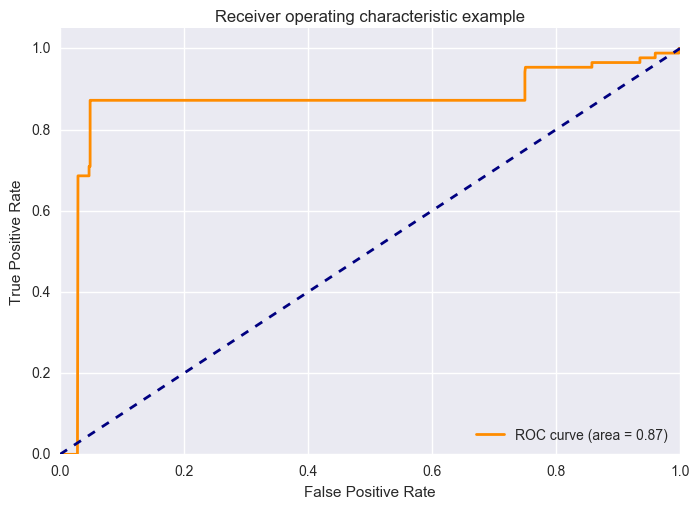

In [60]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [61]:
with open('twitter-consumer-desire-logreg.pkl', 'wb') as f:
    pickle.dump(clf, f, protocol=2)

## Pipeline transformer

In [62]:
import sys
import sklearn.base
from sklearn.pipeline import Pipeline

if sys.version_info.major == 3:
    imap = map
else:
    from itertools import imap

class FeatureExtractor(sklearn.base.TransformerMixin):
    def __init__(self, funcs):
        self.funcs = funcs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """return array of shape [n_samples, n_features]"""
        if isinstance(X, pd.DataFrame):
            iter_ = imap(lambda a: a[1], X.iterrows())
        else:
            iter_ = X
        return tuple(tuple(func(i) for key, func in self.funcs.items()) for i in iter_)
    
    def __getstate__(self):
        return self.funcs
    
    def __setstate__(self, state):
        self.funcs = state


In [63]:
feat_extractor = FeatureExtractor(feat_only_per_rec_funcs)
clf_logreg = LogisticRegression()
clf_pipe = Pipeline([('features', feat_extractor), ('logreg', clf_logreg)])

In [64]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    lab_meta,
    lab_meta['L_d'],
    test_size=0.3,
    random_state=0
)

In [65]:
clf_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('features', <__main__.FeatureExtractor object at 0x123e91208>), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [66]:
clf_pipe.transform(X_test2)

/Users/shajek/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 0],
       ..., 
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 1]])

In [67]:
clf_pipe.steps[1][1].coef_

array([[ 0.0694448 ,  0.        , -1.22359403, -1.41072544, -1.7674736 ,
        -0.93560492, -2.98306409, -0.15768204, -0.01616832]])

In [68]:
clf_pipe.score(X_test2, y_test2)

0.92942109436954801

In [69]:
X_test_proba_pipe = clf_pipe.predict_proba(X_test2)

In [70]:
roc_auc_pipe = metrics.roc_auc_score(y_test2, X_test_proba_pipe[:, 1])
roc_auc_pipe

0.87158832261256802

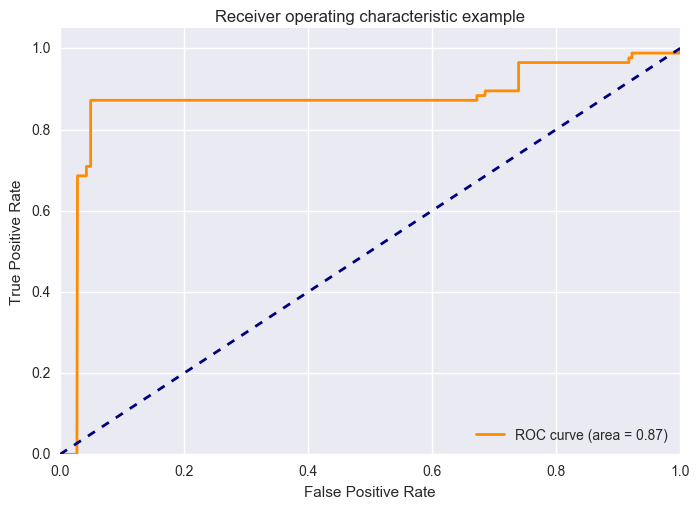

In [71]:
fpr, tpr, thresh = metrics.roc_curve(y_test2, X_test_proba_pipe[:, 1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_pipe)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Pickle within module

In [72]:
import imp

In [73]:
sentiment_service = imp.new_module("sentiment_service")
sys.modules['sentiment_service'] = sentiment_service

sentiment_service.is_field_nonnull = is_field_nonnull
sentiment_service.subfield_getter = subfield_getter
sentiment_service.subfield_func_apply = subfield_func_apply
sentiment_service.FeatureExtractor = FeatureExtractor
sentiment_service.clf_pipe = clf_pipe

In [74]:
'sentiment_service' in sys.modules

True

In [75]:
(sentiment_service.FeatureExtractor.__module__,
sentiment_service.is_field_nonnull.__module__,
sentiment_service.subfield_getter.__module__,
sentiment_service.subfield_func_apply.__module__,
sentiment_service.clf_pipe.__module__,
)

('__main__', '__main__', '__main__', '__main__', 'sklearn.pipeline')

In [76]:
attrs = (
    'FeatureExtractor', 
    'is_field_nonnull', 
    'subfield_getter', 
    'subfield_func_apply', 
)

In [77]:
for _a in attrs:
    getattr(sentiment_service, _a).__module__ = 'sentiment_service'

In [78]:
with open('twitter-consumer-desire-pipe.pkl', 'wb') as f:
    pickle.dump(sentiment_service.clf_pipe, f, protocol=2)